# ***תרגיל 4   של הפרוייקט***

# ***חלק א***

***Cell 1: Load data and basic inspection***




---



In [2]:
import pandas as pd

# Load the filtered dataset from disk (Colab path)
filtered_df = pd.read_csv("/content/train-filtered_question_level.csv")

# Remove duplicate questions to avoid biasing the model with repeated texts
filtered_df = filtered_df.drop_duplicates(subset=["question"], keep="first")

# Sanity check: show columns and first rows to verify the structure
print("Columns in DataFrame:")
print(filtered_df.columns)

print("\nFirst 5 rows:")
print(filtered_df.head())

# Show global label distribution for 'level' (if exists), to understand dataset balance
if "level" in filtered_df.columns:
    print("\nGlobal distribution of 'level':")
    print(filtered_df["level"].value_counts(normalize=True))
else:
    print("\nColumn 'level' not found in DataFrame.")


Columns in DataFrame:
Index(['question', 'level'], dtype='object')

First 5 rows:
                                            question   level
0  Which magazine was started first Arthur's Maga...  medium
1  The Oberoi family is part of a hotel company t...  medium
2  Musician and satirist Allie Goertz wrote a son...    hard
3    What nationality was James Henry Miller's wife?  medium
4  Cadmium Chloride is slightly soluble in this c...  medium

Global distribution of 'level':
level
medium    0.628149
easy      0.198688
hard      0.173162
Name: proportion, dtype: float64


***Cell 2: Text preprocessing (tokenization + lemmatization)***

In [3]:
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag

# Download required NLTK resources (run once per runtime)
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("averaged_perceptron_tagger_eng")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("averaged_perceptron_tagger")
nltk.download("stopwords")

lemmatizer = WordNetLemmatizer()
eng_stops = set(stopwords.words("english"))

# Normalize all forms of the verb "to be" into a single token "be"
BE_FORMS = {"am", "is", "are", "was", "were", "be", "been", "being"}


def get_wordnet_pos(tag: str):
    """
    Map POS tag from nltk.pos_tag to a WordNet POS tag.
    This helps the lemmatizer pick the correct base form.
    """
    if tag.startswith("J"):
        return wordnet.ADJ
    if tag.startswith("V"):
        return wordnet.VERB
    if tag.startswith("N"):
        return wordnet.NOUN
    if tag.startswith("R"):
        return wordnet.ADV
    return wordnet.NOUN


# Regex patterns for cleaning
# Remove URLs, emails, @handles, #hashtags
url_email_handle_re = re.compile(r"(https?://\S+|www\.\S+|\S+@\S+|[@#]\w+)", re.IGNORECASE)

# Detect any digit inside a token
digits_re = re.compile(r"\d")

# For NON-numeric tokens: remove everything except [a-z] and spaces
non_letter_re = re.compile(r"[^a-z ]+")


def process_text_value(text: str) -> str:
    """
    Full preprocessing for a single text value:
    - Remove URLs, emails, and @handles/#hashtags
    - Tokenize
    - POS tagging
    - Lemmatization with POS
    - Normalize all 'be' verb forms to 'be'
    - Any token that contains at least one digit -> '_number' (entire token)
    - For other tokens: strip punctuation/non-letters, keep only [a-z] and spaces
    - Finally, any token that still contains the substring 'number' is collapsed to '_number'
    - (Optional) Remove stopwords [currently commented out]
    - Lowercase
    Returns a cleaned string with space-separated tokens.
    """
    # Safely handle missing or non-string values
    if not isinstance(text, str):
        return ""

    # Remove URLs, emails, handles, hashtags
    t = url_email_handle_re.sub(" ", text)

    # Tokenize and POS-tag on original (cleaned) text
    tokens = word_tokenize(t)
    tagged = pos_tag(tokens)

    lemmas = []
    for tok, pos in tagged:
        # Normalize 'be' forms early to reduce sparsity
        if tok.lower() in BE_FORMS:
            lemmas.append("be")
            continue

        # Map POS tag to WordNet POS tag and lemmatize
        wn_pos = get_wordnet_pos(pos)
        lemma = lemmatizer.lemmatize(tok, wn_pos)
        lemmas.append(lemma)

    # Lowercase all tokens
    lemmas = [w.lower() for w in lemmas]

    intermediate = []
    for w in lemmas:
        # If the token contains ANY digit, replace the entire token with '_number'
        if digits_re.search(w):
            intermediate.append("_number")
            continue

        # For non-numeric tokens: remove punctuation and non-letters
        w2 = non_letter_re.sub(" ", w).strip()
        if not w2:
            # Skip tokens that became empty after cleaning
            continue

        # If cleaning produced multiple parts (e.g. "word-word" -> "word word")
        for part in w2.split():
            if not part:
                continue
            intermediate.append(part)

    # Final pass: collapse any token that still contains 'number' into '_number'
    # This guarantees we do not get '_numbera', '_numberkm', etc.
    clean_lemmas = []
    for w in intermediate:
        if "number" in w:
            clean_lemmas.append("_number")
        else:
            clean_lemmas.append(w)

    clean_lemmas = [w for w in clean_lemmas if w not in eng_stops]

    # Join tokens back into a single cleaned string
    return " ".join(clean_lemmas)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


***Cell 3: Apply preprocessing to all questions***

In [4]:
# Ensure the 'question' column exists before applying preprocessing
if "question" not in filtered_df.columns:
    raise KeyError("The DataFrame does not contain a 'question' column.")

# Apply the preprocessing function to every question in the dataset
# This creates a new column 'question_clean' that contains the normalized text
filtered_df["clean_text"] = filtered_df["question"].apply(process_text_value)

# Inspect a few examples to verify that preprocessing works as expected
print("Original vs. cleaned examples:\n")
for i in range(5):
    print(f"--- Example {i+1} ---")
    print("Original :", filtered_df.loc[filtered_df.index[i], "question"])
    print("Cleaned  :", filtered_df.loc[filtered_df.index[i], "clean_text"])
    print()


Original vs. cleaned examples:

--- Example 1 ---
Original : Which magazine was started first Arthur's Magazine or First for Women?
Cleaned  : magazine start first arthur magazine first women

--- Example 2 ---
Original : The Oberoi family is part of a hotel company that has a head office in what city?
Cleaned  : oberoi family part hotel company head office city

--- Example 3 ---
Original : Musician and satirist Allie Goertz wrote a song about the "The Simpsons" character Milhouse, who Matt Groening named after who?
Cleaned  : musician satirist allie goertz write song simpsons character milhouse matt groening name

--- Example 4 ---
Original :  What nationality was James Henry Miller's wife?
Cleaned  : nationality james henry miller wife

--- Example 5 ---
Original : Cadmium Chloride is slightly soluble in this chemical, it is also called what?
Cleaned  : cadmium chloride slightly soluble chemical also call



***Cell 4: TF-IDF vectorization of the preprocessed questions***

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Safety check: make sure 'clean_text' exists
if "clean_text" not in filtered_df.columns:
    raise KeyError("The DataFrame does not contain a 'clean_text' column. "
                   "Run the preprocessing cell first.")

# Define a TF-IDF vectorizer
# max_features limits vocabulary size to the most frequent terms
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,   # limit vocabulary size (you can tune this later)
    ngram_range=(1, 1),   # unigrams only
)

# Fit TF-IDF on the entire cleaned corpus and transform it to a sparse matrix
# Each row = one question, each column = one term from the vocabulary
X_tfidf = tfidf_vectorizer.fit_transform(filtered_df["clean_text"])

print("TF-IDF matrix shape (n_samples, n_features):", X_tfidf.shape)
print("(Num of documents, max_features)")

# Optional: extract labels if you need them later for supervised models / evaluation
if "level" in filtered_df.columns:
    y = filtered_df["level"].values
    print("Labels vector shape:", y.shape)
else:
    y = None
    print("No 'level' column found. y is set to None.")

# Show a small sample of feature names for sanity check
feature_names = tfidf_vectorizer.get_feature_names_out()
print("\nVocabulary size (len(feature_names)):", len(feature_names))
print("First 30 features:\n", feature_names[:60])


TF-IDF matrix shape (n_samples, n_features): (90418, 10000)
(Num of documents, max_features)
Labels vector shape: (90418,)

Vocabulary size (len(feature_names)): 10000
First 30 features:
 ['_number' 'aaa' 'aaron' 'ab' 'abandon' 'abashidze' 'abba' 'abbey' 'abbot'
 'abbott' 'abbreviate' 'abbreviation' 'abc' 'abdication' 'abduct' 'abdul'
 'abe' 'abel' 'aberdeen' 'abigail' 'ability' 'able' 'aboard'
 'abolitionist' 'aboriginal' 'abraham' 'abrams' 'absent' 'absorb'
 'abstract' 'abu' 'abuse' 'ac' 'academic' 'academy' 'accept' 'access'
 'accessible' 'accessory' 'accident' 'acclaim' 'acclaimed' 'accompany'
 'accomplished' 'accomplishment' 'accord' 'according' 'account' 'accra'
 'accredit' 'accuse' 'ace' 'achieve' 'achievement' 'acid' 'acknowledge'
 'acorn' 'acoustic' 'acquire' 'acquisition']


***Cell 5: Run K-Means for different K values***

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Choose several K values
k_values = [2, 7 ,15]
# k_values = [2]
inertia_scores = []
silhouette_scores = []

print("Running K-Means on TF-IDF matrix... (may take a bit)")

for k in k_values:
    print(f"\n--- K = {k} ---")

    # KMeans (using smart initialization k-means++)
    kmeans = KMeans(
        n_clusters=k,
        init="k-means++",
        max_iter=300,
        random_state=42,
        n_init=10
    )

    # Fit on full TF-IDF matrix
    kmeans.fit(X_tfidf)

    # Inertia (Elbow)
    inertia = kmeans.inertia_
    inertia_scores.append(inertia)

    # Silhouette score (requires >1 cluster)
    sil_score = silhouette_score(X_tfidf, kmeans.labels_, metric='euclidean')
    silhouette_scores.append(sil_score)

    print(f"Inertia: {inertia}")
    print(f"Silhouette Score: {sil_score}")


Running K-Means on TF-IDF matrix... (may take a bit)

--- K = 2 ---
Inertia: 89075.67973869988
Silhouette Score: 0.002867427356320255

--- K = 7 ---
Inertia: 87634.0329391749
Silhouette Score: 0.007785830880602162

--- K = 15 ---
Inertia: 86323.62648750006
Silhouette Score: 0.011563243957628406


**Cell 6: Dimensionality reduction for clustering (TruncatedSVD)**

In [7]:
from sklearn.decomposition import TruncatedSVD

# We reduce dimensionality because TF-IDF has many features and is sparse.
# TruncatedSVD is PCA-like but works directly on sparse matrices.
svd = TruncatedSVD(
    n_components=50,   # number of latent dimensions (you can tune this)
    random_state=42
)

# Fit SVD on the TF-IDF matrix and transform it to a dense lower-dimensional space
X_svd = svd.fit_transform(X_tfidf)

print("Original TF-IDF shape :", X_tfidf.shape)
print("Reduced SVD shape     :", X_svd.shape)

# Sum of explained variance ratio gives an idea how much information we kept
explained = svd.explained_variance_ratio_.sum()
print(f"Total explained variance (approx): {explained:.3f}")


Original TF-IDF shape : (90418, 10000)
Reduced SVD shape     : (90418, 50)
Total explained variance (approx): 0.129


***Cell 7: DBSCAN clustering on reduced space and comparison***

In [8]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd

# הגדרת גודל המדגם
SAMPLE_SIZE = 20000

print(f"Original dataset size: {X_svd.shape[0]}")

# 1. דגימה (אם צריך)
if X_svd.shape[0] > SAMPLE_SIZE:
    print(f"Dataset is too large. Sampling {SAMPLE_SIZE} random points...")
    np.random.seed(42)
    indices = np.random.choice(X_svd.shape[0], SAMPLE_SIZE, replace=False)
    X_subset = X_svd[indices]
    df_subset = filtered_df.iloc[indices].copy()
else:
    X_subset = X_svd
    df_subset = filtered_df.copy()

print(f"Running DBSCAN on {X_subset.shape[0]} samples...")

# 2. הרצת DBSCAN
dbscan = DBSCAN(eps=0.1, min_samples=50, metric='cosine', n_jobs=-1) #.........................................................................
dbscan_labels = dbscan.fit_predict(X_subset)
print("DBSCAN finished!")

# 3. שמירת תוצאות
df_subset['dbscan_cluster'] = dbscan_labels

# 4. ניתוח בסיסי
unique_labels, counts = np.unique(dbscan_labels, return_counts=True)
print("\nCluster counts (Label -1 represents 'Noise'):")
print(dict(zip(unique_labels, counts)))

# 5. חישוב Silhouette Score (בטוח)
# בדיקה כמה אשכולות יש שאינם רעש
n_clusters_real = len(set(dbscan_labels) - {-1})

if n_clusters_real >= 2:
    non_noise_mask = dbscan_labels != -1
    sil = silhouette_score(X_subset[non_noise_mask], dbscan_labels[non_noise_mask])
    print(f"\nDBSCAN Silhouette Score (excluding noise): {sil:.4f}")
else:
    print(f"\nCould not calculate Silhouette Score: Found {n_clusters_real} real clusters.")
    print("Silhouette Score requires at least 2 distinct clusters.")
    print("Try adjusting 'eps' (lower it to split clusters) or 'min_samples'.")

Original dataset size: 90418
Dataset is too large. Sampling 20000 random points...
Running DBSCAN on 20000 samples...
DBSCAN finished!

Cluster counts (Label -1 represents 'Noise'):
{np.int64(-1): np.int64(14056), np.int64(0): np.int64(173), np.int64(1): np.int64(943), np.int64(2): np.int64(254), np.int64(3): np.int64(115), np.int64(4): np.int64(185), np.int64(5): np.int64(212), np.int64(6): np.int64(224), np.int64(7): np.int64(299), np.int64(8): np.int64(89), np.int64(9): np.int64(100), np.int64(10): np.int64(122), np.int64(11): np.int64(217), np.int64(12): np.int64(130), np.int64(13): np.int64(109), np.int64(14): np.int64(136), np.int64(15): np.int64(121), np.int64(16): np.int64(128), np.int64(17): np.int64(138), np.int64(18): np.int64(128), np.int64(19): np.int64(71), np.int64(20): np.int64(82), np.int64(21): np.int64(251), np.int64(22): np.int64(150), np.int64(23): np.int64(83), np.int64(24): np.int64(196), np.int64(25): np.int64(83), np.int64(26): np.int64(166), np.int64(27): np.i

***Cell 8: Analyze DBSCAN Clusters (Top Keywords & Sample Questions)***

In [9]:
# === Cell 8: Questions by Category (Clusters) ===

import pandas as pd
import numpy as np

print("Printing Questions by Cluster (DBSCAN Results)...")

# 1. וידוא שמשתני המדגם קיימים
if 'df_subset' not in locals():
    df_subset = filtered_df

# 2. הוספת התוויות למדגם
df_subset['dbscan_cluster'] = dbscan_labels

unique_labels = np.sort(np.unique(dbscan_labels))

# מעבר על כל אשכול והצגת השאלות בלבד
for label in unique_labels:
    print(f"\n{'='*60}")

    if label == -1:
        print(f"CATEGORY: NOISE / UNCLASSIFIED QUESTIONS")
    else:
        print(f"CATEGORY: CLUSTER {label}")

    print(f"{'='*60}")

    # שליפת כל השאלות השייכות לאשכול הנוכחי
    cluster_questions = df_subset[df_subset['dbscan_cluster'] == label]['question'].values
    cluster_size = len(cluster_questions)

    print(f"Total questions in this category: {cluster_size}")
    print("-" * 30)

    # הצגת דוגמאות (נציג עד 15 שאלות כדי לא להציף, אתה יכול לשנות את המספר)
    display_count = min(15, cluster_size)
    for i in range(display_count):
        print(f" {i+1}. {cluster_questions[i]}")

    if cluster_size > display_count:
        print(f" ... and {cluster_size - display_count} more questions.")

print(f"\n{'='*60}")
print("Analysis Complete.")

Printing Questions by Cluster (DBSCAN Results)...

CATEGORY: NOISE / UNCLASSIFIED QUESTIONS
Total questions in this category: 14056
------------------------------
 1. What types of music strongly influenced the composer of Concerto Grosso?
 2. Pippalada was an ancient Indian Vedic sage who was known to have written which ancient Sanskrit text, embedded inside Atharva Veda?
 3. What is the common name for the hostplant of Phyllocnistis Iiriodendronella that is a tree of the family Magnoliaceae?
 4. In & Out is a 1997 American romantic comedy film directed by Frank Oz and starring Kevin Delaney Kline, an American film and stage actor and singer, he's won how many Tony Awards, among other various awards?
 5. What coming-of-age, South Korean television series earned Lee Jun-hyeok the award for Best Supporting Actor at the 30th KBS Drama Awards? 
 6. Which has more acts: Die Walküre or Cendrillon?
 7.  "Sleep to Dream" is a song written and recorded by an American alternative singer-songwri

**Cell 9: Visualization by t-SNE & PCA**

Subsampling to 5000 points for t-SNE calculation...
Running t-SNE... (This may take a minute)


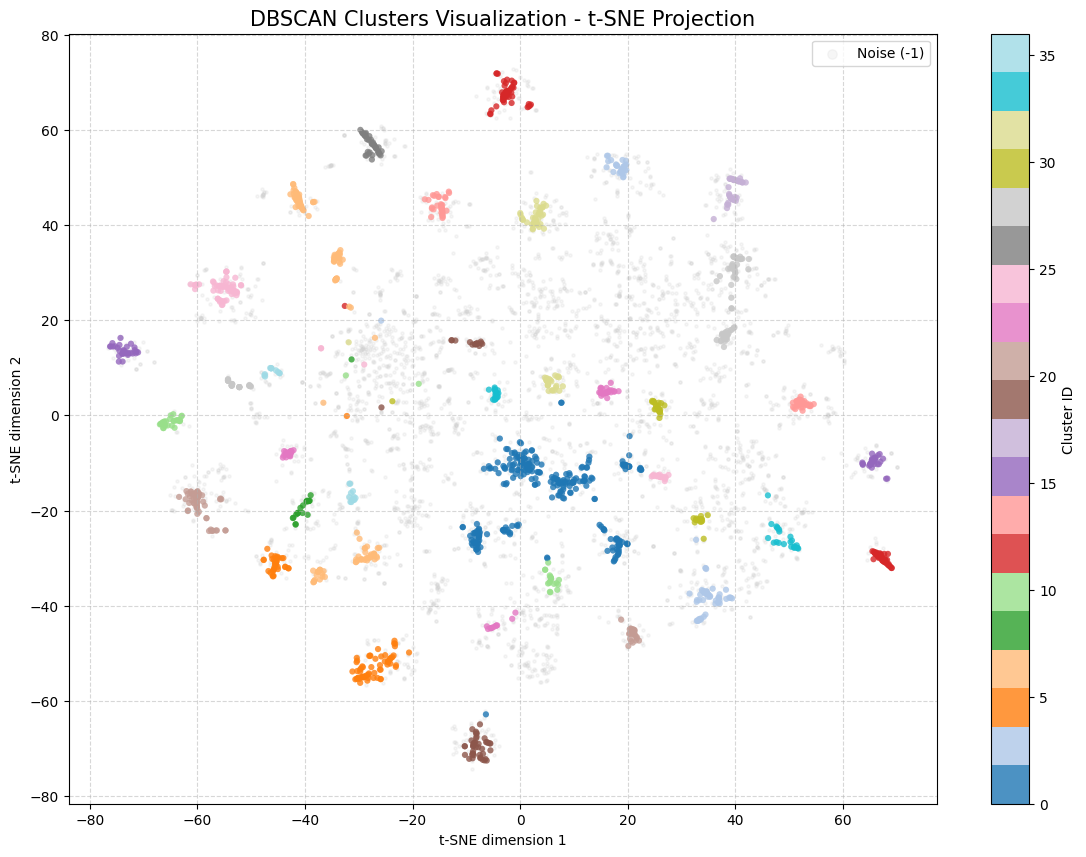

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

# בדיקת משתנים
if 'X_subset' not in locals() or 'dbscan_labels' not in locals():
    raise ValueError("Missing variables! Please run the sampling & DBSCAN cell first.")

labels_to_plot = dbscan_labels
X_plot_data = X_subset

# הגבלת דגימה ל-t-SNE (אופטימיזציה)
TSNE_LIMIT = 5000
if len(labels_to_plot) > TSNE_LIMIT:
    print(f"Subsampling to {TSNE_LIMIT} points for t-SNE calculation...")
    np.random.seed(42)
    indices_tsne = np.random.choice(len(labels_to_plot), TSNE_LIMIT, replace=False)
    X_tsne_input = X_plot_data[indices_tsne]
    labels_tsne = labels_to_plot[indices_tsne]
else:
    X_tsne_input = X_plot_data
    labels_tsne = labels_to_plot

print("Running t-SNE... (This may take a minute)")
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto', perplexity=30)
X_tsne_2d = tsne.fit_transform(X_tsne_input)

# יצירת התרשים
plt.figure(figsize=(14, 10))

# הפרדה בין רעש לאשכולות
noise_mask = (labels_tsne == -1)
cluster_mask = ~noise_mask

# ציור הרעש (Noise) באפור בהיר מאוד
plt.scatter(X_tsne_2d[noise_mask, 0], X_tsne_2d[noise_mask, 1],
            c='lightgray', label='Noise (-1)', s=5, alpha=0.2)

# ציור האשכולות (Clusters)
scatter = plt.scatter(X_tsne_2d[cluster_mask, 0], X_tsne_2d[cluster_mask, 1],
            c=labels_tsne[cluster_mask], cmap='tab20', s=20, alpha=0.8, edgecolors='none')

plt.title('DBSCAN Clusters Visualization - t-SNE Projection', fontsize=15)
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')

# הוספת Colorbar רק אם יש אשכולות
if np.any(cluster_mask):
    plt.colorbar(scatter, label='Cluster ID')

plt.legend(markerscale=3, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

**Cell 10: Calculating Purity Score**

In [11]:
from sklearn.metrics import adjusted_rand_score
import pandas as pd
import numpy as np

# וודא שאתה לוקח את התוויות המקוריות מהמדגם שהרצת עליו את ה-DBSCAN
true_labels = df_subset['level']

# חישוב ה-ARI
ari_score = adjusted_rand_score(true_labels, dbscan_labels)

# פונקציה לחישוב Purity
def calculate_purity(y_true, y_pred):
    contingency_matrix = pd.crosstab(y_true, y_pred)
    return np.sum(contingency_matrix.max(axis=0)) / np.sum(contingency_matrix.values)

purity_score = calculate_purity(true_labels, dbscan_labels)

print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
print(f"Purity Score: {purity_score:.4f}")

Adjusted Rand Index (ARI): -0.0016
Purity Score: 0.6313


# **חלק ב- חילוץ קשרים**

**Cell 11: Run TF-IDF and find the top words**

---



In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

def print_just_keywords_by_cluster(df, cluster_col, text_col, top_n=50):
    # 1. הגדרת הוקטורייזר לניקוי מילים נפוצות
    vec = TfidfVectorizer(stop_words='english')

    # 2. איחוד הטקסטים לפי אשכול (דילוג על רעש)
    relevant_data = df[df[cluster_col] != -1]
    docs = relevant_data.groupby(cluster_col)[text_col].apply(lambda x: ' '.join(x))

    # 3. חישוב TF-IDF
    tfidf_matrix = vec.fit_transform(docs)
    features = vec.get_feature_names_out()

    print("Printing Keywords for Each Cluster...")
    print("=" * 60)

    for i, cluster_id in enumerate(docs.index):
        # שליפת הציונים ומיון המילים מהחזקה לחלשה
        row = tfidf_matrix[i].toarray().flatten()
        all_word_indices = row.argsort()[::-1]

        # לקיחת המילים שיש להן משקל חיובי (עד הכמות שביקשנו)
        keywords = [features[idx] for idx in all_word_indices if row[idx] > 0][:top_n]

        cluster_size = len(df[df[cluster_col] == cluster_id])

        # הדפסת הכותרת והמילים
        print(f"CATEGORY: CLUSTER {cluster_id} ({cluster_size} questions)")
        print("-" * 30)

        # הדפסה של המילים מופרדות בפסיקים
        print(", ".join(keywords))

        print("\n" + "=" * 60 + "\n")

# הרצת הפונקציה - תדפיס את 50 המילים המובילות לכל אשכול
print_just_keywords_by_cluster(df_subset, 'dbscan_cluster', 'question', top_n=50)

Printing Keywords for Each Cluster...
CATEGORY: CLUSTER 0 (173 questions)
------------------------------
year, years, did, born, president, died, established, die, king, battle, away, built, emperor, könig, minister, served, passed, man, birth, brawl, founder, debut, beginning, uganda, ruled, pass, monarch, political, end, prime, replaced, appointed, prize, dedicated, colony, calendar, wounded, clausius, assassinate, patek, created, england, princess, head, air, father, person, ronald, easter, occur


CATEGORY: CLUSTER 1 (943 questions)
------------------------------
named, born, held, june, april, 2014, november, did, 2009, august, 2017, number, 2016, february, 2011, july, war, village, 2015, season, general, world, march, 15, october, september, election, 2010, 2012, politician, gun, 30, took, champion, january, england, series, event, king, 2013, man, driver, 13, 2008, place, 2007, grand, 500, middle, racing


CATEGORY: CLUSTER 2 (254 questions)
------------------------------
band, 

# 🏷️ Final Topic Identification per Cluster

The following table summarizes the semantic interpretation of each cluster identified by DBSCAN. The labels were derived by analyzing the top TF-IDF keywords within each group:

| Cluster ID | Identified Topic Title |
| :--- | :--- |
| **0** | Historical Chronology & Governance |
| **1** | Dated Biographies & Global Events |
| **2** | Music Bands & Rock Culture |
| **3** | Authorship & Literary Works |
| **4** | Geographic Landmarks & Districts |
| **5** | Academic Institutions & Research |
| **6** | Professional Peer Comparisons |
| **7** | US Counties & Civil Geography |
| **8** | Occupational Scopes & Shared Roles |
| **9** | Aviation & International Airports |
| **10** | Creative Works & Shared Nationalities |
| **11** | Biographical Name Studies (Common Names) |
| **12** | Gaming, Boards & Software Development |
| **13** | Historical Battles & Operatic Works |
| **14** | Biographical Milestones & Relationships |
| **15** | Periodicals, Magazines & Publishing |
| **16** | US Government & Military Service |
| **17** | Global Urban Centers & Provinces |
| **18** | Music Theory & Classical Genres |
| **19** | Parliamentary Bodies & Political Parties |
| **20** | Film Festivals & International Directors |
| **21** | Territorial Origins & Bordering Regions |
| **22** | Team Sports & Athletic Positions |
| **23** | Corporate Foundations & Business Entities |
| **24** | Scientific Laws & Cultural Formulas |
| **25** | Comparative Birth Dates & Genealogy |
| **26** | Entertainment Media & Commodity Types |
| **27** | Biological Taxonomy (Genus & Species) |
| **28** | Cinematic Genres & Film Productions |
| **29** | Vocalists & Contemporary Songwriters |
| **30** | Social Activism & Political Figures |
| **31** | Public Recognition & Historical Legacy |
| **32** | Awards, Honors & Academic Prizes |
| **33** | Music Studio Albums & Discography |
| **34** | State Governance & Regional Landmarks |
| **35** | Professional Athlete Rankings (Tennis/Hockey) |
| **36** | Work Environments & Intellectual Contributions |
| **37** | Botany & Floral Species |
| **38** | Institutional Foundations & Societies |
| **39** | Screenwriting & Stage Direction |
| **40** | Animated Television & Series Production |

---

# **חלק ג- ניתוח בלשני, חילוץ קשרים**

# 🔍 Step C: Linguistic Exploration & Advanced Refinement

In this stage, we analyze the quality of the relations extracted from **Cluster 1** and **Cluster 11**. Our goal is to evaluate the basic NLP tools and implement a refined logic to improve information extraction.


**Cell 12: Setup and Configuration**

In [13]:
# Cell 1: Setup and Configuration

import spacy
import pandas as pd
import numpy as np

ז
# Select the clusters for in-depth linguistic analysis (Step 1 requirement)
CLUSTERS_TO_ANALYZE = [1,11]
SAMPLE_SIZE = 25 # Sample size required (20-30 questions per cluster)

# --- Load SpaCy Model ---
try:
    # Loading the large model for better accuracy in Dependency Parsing
    nlp = spacy.load("en_core_web_sm")
    print("SpaCy model loaded successfully.")
except:
    print("CRITICAL ERROR: SpaCy model not loaded. Ensure 'en_core_web_sm' is installed.")
    raise

SpaCy model loaded successfully.


In [14]:
# התקנת ספריית textacy
!pip install textacy

import spacy
import pandas as pd
import textacy
from spacy.matcher import Matcher

# טעינת מודל השפה
try:
    nlp = spacy.load("en_core_web_sm")
    print("SpaCy and Textacy are ready!")
except:
    !python -m spacy download en_core_web_sm
    nlp = spacy.load("en_core_web_sm")

# וודא ש-df_working מכיל את האשכולות (cluster_labels)
# (נניח ש-df_subset הוא ה-dataframe שלך מהשלב הקודם)
df_working = df_subset.copy()
if 'dbscan_cluster' not in df_working.columns:
    df_working['dbscan_cluster'] = dbscan_labels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.6/321.6 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.5/360.5 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 85.0 MB/s eta 0:00:00
SpaCy and Textacy are ready!


**Cell 13: Defining Basic Relation Extraction Functions (SVO, Attribute, Location)**

In [15]:
import textacy

def extract_svo_basic(doc):
    """Subject-Verb-Object Extraction"""
    triples = []
    svos = list(textacy.extract.triples.subject_verb_object_triples(doc))
    for svo in svos:
        triples.append({
            'Entity 1': " ".join([t.text for t in svo.subject]),
            'Relation': " ".join([t.text for t in svo.verb]),
            'Entity 2': " ".join([t.text for t in svo.object]),
            'Type': 'SVO (Basic)'
        })
    return triples

def extract_entity_attribute(doc):
    """Entity-Attribute Extraction"""
    triples = []
    for token in doc:
        if token.pos_ == "NOUN":
            for child in token.children:
                if child.dep_ == "amod":
                    triples.append({'Entity 1': token.text, 'Relation': 'HAS_ATTR', 'Entity 2': child.text, 'Type': 'Attribute'})
        if token.lemma_ == "be":
            subj = [w for w in token.lefts if "subj" in w.dep_]
            attr = [w for w in token.rights if w.dep_ in ["attr", "acomp"]]
            if subj and attr:
                triples.append({'Entity 1': subj[0].text, 'Relation': 'IS_A', 'Entity 2': attr[0].text, 'Type': 'Attribute'})
    return triples

def extract_entity_location(doc):
    """Entity-Location Extraction"""
    triples = []
    for ent in doc.ents:
        if ent.label_ in ["GPE", "LOC"]:
            triples.append({'Entity 1': ent.root.head.text, 'Relation': 'LOCATED_IN', 'Entity 2': ent.text, 'Type': 'Location'})
    return triples

**Cell 14: Execution on Sample and Storing Results**

In [16]:
all_basic_triples = []

for cluster_id in CLUSTERS_TO_ANALYZE:
    cluster_data = df_working[df_working['dbscan_cluster'] == cluster_id]
    sample = cluster_data.sample(min(SAMPLE_SIZE, len(cluster_data)), random_state=42)

    for q in sample['question']:
        doc = nlp(q)
        res = extract_svo_basic(doc) + extract_entity_attribute(doc) + extract_entity_location(doc)
        for r in res:
            r['Cluster'] = cluster_id
            r['Question'] = q
            all_basic_triples.append(r)

df_triples_output = pd.DataFrame(all_basic_triples)
print(f"Generated {len(df_triples_output)} basic triples.")
df_triples_output.head(20)

Generated 88 basic triples.


,Entity 1,Relation,Entity 2,Type,Cluster,Question
0,What,stretches,Ridge Mountains,SVO (Basic),1,What stretches about 1200 miles and borders th...
1,What,borders,Ridge Mountains,SVO (Basic),1,What stretches about 1200 miles and borders th...
2,Clyde Snow,identified,that,SVO (Basic),1,What was the gender of the 1970s murder victim...
3,president,HAS_ATTR,55th,Attribute,1,Which 55th president of Mexico was involved in...
4,of,LOCATED_IN,Mexico,Location,1,Which 55th president of Mexico was involved in...
5,which,differentiate,Apple A7 A8 system,SVO (Basic),1,what is the term which differentiate the Apple...
6,single,HAS_ATTR,second,Attribute,1,Wrist serves as the second single from what mi...
7,raid,HAS_ATTR,famous,Attribute,1,What did Joe McCarthy's famous raid in 1943 at...
8,it,has,perihelion distance,SVO (Basic),1,5786 Talos (1991 RC) is an Apollo asteroid dis...
9,asteroids,have,AU Icarus Phaethon,SVO (Basic),1,5786 Talos (1991 RC) is an Apollo asteroid dis...


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('Type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Question').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Cluster']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Cluster'}, axis=1)
              .sort_values('Cluster', ascending=True))
  xs = counted['Cluster']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('Cluster', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Type')):
  _plot_series(series, series_name, i)
  fig.legend(title='Type', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Cluster')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Cluster']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Cluster'}, axis=1)
              .sort_values('Cluster', ascending=True))
  xs = counted['Cluster']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('Cluster', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Question')):
  _plot_series(series, series_name, i)
  fig.legend(title='Question', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Cluster')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Question'].value_counts()
    for x_label, grp in _df_4.groupby('Type')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Type')
_ = plt.ylabel('Question')

from matplotlib import pyplot as plt
_df_5['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_6.groupby('Type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_7.groupby('Question').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Type')):
  _plot_series(series, series_name, i)
  fig.legend(title='Type', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Question')):
  _plot_series(series, series_name, i)
  fig.legend(title='Question', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Cluster']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Cluster'}, axis=1)
              .sort_values('Cluster', ascending=True))
  xs = counted['Cluster']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('Cluster', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Type')):
  _plot_series(series, series_name, i)
  fig.legend(title='Type', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Cluster')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Cluster']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Cluster'}, axis=1)
              .sort_values('Cluster', ascending=True))
  xs = counted['Cluster']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('Cluster', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Question')):
  _plot_series(series, series_name, i)
  fig.legend(title='Question', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Cluster')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_12['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Question'].value_counts()
    for x_label, grp in _df_13.groupby('Type')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Type')
_ = plt.ylabel('Question')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['Type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='index', y='Type', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['Question'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='index', y='Question', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [20]:
from spacy.matcher import Matcher

def extract_refined_trivia_knowledge(doc):
    """
    Improved logic for Step C:
    - Eliminates 'Who', 'Which', and noise words like 'by'.
    - Merges fragmented dates (e.g., '10 June 2013') into one string.
    - Strictly focuses on real Named Entities (Proper Nouns).
    """
    matcher = Matcher(nlp.vocab)

    # Pattern: [Proper Noun Entity] -> [Optional Bridge/Verb] -> [Target Date/Location]
    # This forces Entity 1 to be a real name, skipping pronouns or prepositions.
    pattern = [
        {"ENT_TYPE": {"IN": ["PERSON", "GPE", "ORG"]}, "POS": "PROPN"}, # Subject (Proper Noun)
        {"POS": {"IN": ["VERB", "AUX", "ADP"]}, "OP": "*"},           # Connectors/Verbs
        {"ENT_TYPE": {"IN": ["DATE", "GPE", "CARDINAL"]}, "OP": "+"}  # Target (Date/Place)
    ]

    matcher.add("REFINED_FACT", [pattern])
    matches = matcher(doc)
    results = []

    for match_id, start, end in matches:
        span = doc[start:end]

        # Filter: Identify the primary Named Entity (must be a proper noun)
        e1_list = [t.text for t in span if t.ent_type_ in ["PERSON", "GPE", "ORG"] and t.pos_ == "PROPN"]
        if not e1_list: continue
        entity_1 = e1_list[0]

        # Merge target information (Dates/Locations) while avoiding duplicating Entity 1
        e2_parts = [t.text for t in span if (t.ent_type_ in ["DATE", "GPE", "CARDINAL"]) and t.text != entity_1]
        entity_2 = " ".join(e2_parts)

        if entity_1 and entity_2:
            results.append({
                'Entity 1': entity_1,
                'Relation': 'ASSOCIATED_WITH_EVENT',
                'Entity 2': entity_2,
                'Type': 'Refined-Event-Date'
            })

    return results

# Applying the refined logic to the unique questions identified in previous steps
refined_triples = []
unique_questions = df_triples_output['Question'].unique()

for q in unique_questions:
    refined_triples.extend(extract_refined_trivia_knowledge(nlp(q)))

df_refined_results = pd.DataFrame(refined_triples).drop_duplicates()

print(f"Refined Extraction complete. Found {len(df_refined_results)} high-quality factual triples.")
df_refined_results.head(20)

Refined Extraction complete. Found 3 high-quality factual triples.


,Entity 1,Relation,Entity 2,Type
0,Mint,ASSOCIATED_WITH_EVENT,1936,Refined-Event-Date
1,Beijing,ASSOCIATED_WITH_EVENT,1987,Refined-Event-Date
2,Universe,ASSOCIATED_WITH_EVENT,1998,Refined-Event-Date
